<a href="https://colab.research.google.com/github/mp5557/foo/blob/main/lane_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare

In [ ]:
# !git clone https://github.com/mp5557/lane_detection.git
# !pip install pytorch-lightning
# !wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/train_set.zip
# !unzip train_set.zip

# Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch

from torch.optim import SGD, Adam, lr_scheduler, RMSprop
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from os import path

from lane_detection.tusimple_dataset import *


class TusimpleDataModule(pl.LightningDataModule):
    def __init__(self, root_path, anno_path_list, num_workers=8, batch_size=16, *args, **kw_args) -> None:
        super().__init__()

        self.num_workers = num_workers
        self.batch_size = batch_size

        anno_list = TusimpleDataset.getAnnotationList(
            root_path, anno_path_list)
        num_sample = int(0.9 * len(anno_list))
        train_anno, val_anno = torch.utils.data.random_split(
            anno_list, [num_sample, len(anno_list) - num_sample])
        self.train_ds = TusimpleDataset(root_path, train_anno,
                                        TensorConverter(RandomHomograpy(0.05, 10, 100, 50)))
        self.val_ds = TusimpleDataset(root_path, val_anno, TensorConverter())

    def train_dataloader(self, *args, **kwargs):
        return torch.utils.data.DataLoader(self.train_ds, num_workers=self.num_workers,
                                           batch_size=self.batch_size)

    def val_dataloader(self, *args, **kwargs):
        return torch.utils.data.DataLoader(self.val_ds, num_workers=self.num_workers,
                                           batch_size=self.batch_size)

# Module

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch

from lane_detection.erfnet import non_bottleneck_1d, Encoder

class Head(nn.Module):
    def __init__(self, input_dim, output_dim) -> None:
        super().__init__()
        self.model = nn.Sequential(
            non_bottleneck_1d(input_dim, 0.5, 2),
            nn.Conv2d(
                input_dim, output_dim, 1, stride=1, padding=0, bias=True))

    def forward(self, x):
        return self.model(x)


class Model(nn.Module):
    def __init__(self, instance_num=8) -> None:
        super().__init__()
        self.backbone = Encoder()
        self.seg_head = Head(self.backbone.dim, instance_num)

    def forward(self, x):
        feature = self.backbone(x)
        lane_segment = self.seg_head(feature)
        return dict(lane_segment=lane_segment)


In [ ]:
from scipy.optimize import linear_sum_assignment

class HungarianLoss(nn.Module):
  def __init__(self):
    super().__init__()
    self.loss = nn.BCEWithLogitsLoss()
  
  @torch.no_grad()
  def match(self, target, lane_segment):
    btarget, bpred = torch.broadcast_tensors(target.unsqueeze(1), lane_segment.unsqueeze(2))
    loss_val = F.binary_cross_entropy_with_logits(bpred, btarget.float(), reduction='none'
                            ).mean(dim=(3, 4)).cpu()
    ind_list = [linear_sum_assignment(lo)[1] for lo in loss_val]
    return ind_list
  
  def forward(self, target, lane_segment, *args, **kwargs):
    batch_num = target.shape[0]
    ind_list = self.match(target, lane_segment)
    loss_list = []
    for bid in range(batch_num):
      loss_list.append(self.loss(lane_segment[bid], target[bid][ind_list[bid]].float()))
    return torch.mean(torch.stack(loss_list))

In [ ]:

class ErfnetModule(pl.LightningModule):
  def __init__(self, num_epochs, *args, **kwargs) -> None:
    super().__init__()
    self.num_epochs = num_epochs
    self.save_hyperparameters('num_epochs')

    self.model = Model()

    self.criterion_list = nn.ModuleDict(
        dict(seg_loss=HungarianLoss()))

  def forward(self, x):
    return self.model(x)

  def configure_optimizers(self):
    optimizer = Adam(self.model.parameters(), 1e-3, weight_decay=1e-5)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 32)

    return [optimizer], [scheduler]

  def training_step(self, batch, batch_idx):
    data, target = batch

    output = self(data)

    loss = 0.
    for loss_name, criterion in self.criterion_list.items():
        loss_curr = criterion(target, **output)
        loss = loss_curr + loss
        self.log(f'loss/train_{loss_name}', loss_curr)
    self.log(f'loss/train', loss)
    return loss

  def validation_step(self, batch, batch_idx):
    data, target = batch
    with torch.no_grad():
      output = self(data)

      loss = 0.
      for loss_name, criterion in self.criterion_list.items():
        loss_curr = criterion(target, **output)
        loss = loss_curr + loss
        self.log(f'loss/val_{loss_name}', loss_curr)
      self.log(f'loss/val', loss)


In [ ]:
root_path = '.'
anno_path_list = ['label_data_0531.json',
                  'label_data_0601.json', 'label_data_0313.json']

data_module = TusimpleDataModule(root_path, anno_path_list)

max_epoch = 100

pl_model = ErfnetModule(max_epoch)

checkpoint_callback = ModelCheckpoint(monitor='loss/val')
lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(gpus=1, max_epochs=max_epoch, callbacks=[lr_monitor, checkpoint_callback])
trainer.fit(pl_model, data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params
----------------------------------------------
0 | model          | Model      | 2.1 M 
1 | criterion_list | ModuleDict | 0     
----------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.291     Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [ ]:
loader = iter(data_module.val_dataloader())

# %%
img, labels = next(loader)
with torch.no_grad():
  output = pl_model(img)
  pred = output['lane_segment'].sigmoid()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


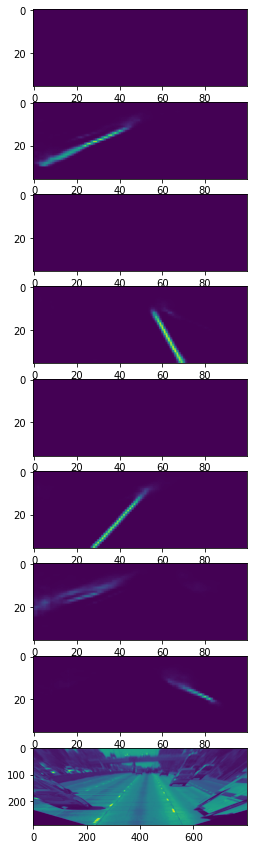

In [ ]:
frame_id = 7
fig, ax = plt.subplots(9, figsize=(15,15))
ax[-1].imshow(img[frame_id].sum(axis=0))
for idx in range(8):
  ax[idx].imshow(pred[frame_id, idx], vmin=0., vmax=1.)
